In [1]:
from typing import Union
import os
import io
import pandas as pd
import random as rd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import requests
import pingouin as pg
import pandahouse as ph
from urllib.parse import urlencode

os.environ['OUTDATED_IGNORE']='1' 

%matplotlib inline

SETTINGS_CELL

In [2]:
# sns.set(
#     font_scale=2,
#     style='whitegrid',
#     rc = {'figure.figsize': (20, 7)}
# )

# Проект: вариант 2 #

### Задание 1. A/B–тестирование ###

**1.1 Условие**

*Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.*

**1.2 Входные данные**

- **groups.csv** - *файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (**А – контроль, B – целевая группа**)*
- **groups_add.csv** - *дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных*
- **active_studs.csv** - *файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.* 
- **checks.csv** - *файл с информацией об оплатах пользователей в дни проведения эксперимента.*

In [3]:
def get_ydisc_public_data_csv(file_url: 'str', **kwargs) -> pd.DataFrame():
    """
    Скачивает данные по публичной ссылке из Яндекс Диска и заносит их в DataFrame
    """
    base = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base + urlencode(dict(public_key=file_url))
    response = requests.get(url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    data = pd.read_csv(io.BytesIO(download_response.content), **kwargs)
    return data

In [25]:
def permutation_test(a_res: pd.DataFrame, b_res: pd.DataFrame, column: str, statistic, n: int=1000):
    """
    Проводит перестановочный тест
    """
    joined_data = list(a_res[column].values)
    joined_data.extend(b_res[column].values)
    result = []
    for i in range(n):
        rd.shuffle(joined_data)
        a_perm = joined_data[:len(a_res)]
        b_perm = joined_data[len(a_res):]
        a_stat = statistic(a_perm)
        b_stat = statistic(b_perm)
        result.append(a_stat - b_stat)
    return result
        

In [5]:
def mean_confidence_interval(data, confidence=0.95):
    """
    Возвращает среднее по совокупности и его доверительный интервал
    """
    a = 1.0 * np.array(data)
    n = len(a)
    m, std = np.mean(a), np.std(a)
    h = std * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m, 4), round(m-h, 4), round(m+h, 4)

C:\Users\1\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\1\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
groups_url = r'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = r'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = r'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = r'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [7]:
groups = get_ydisc_public_data_csv(groups_url, sep=';')

In [8]:
groups_add = get_ydisc_public_data_csv(groups_add_url)


In [9]:
active_studs = get_ydisc_public_data_csv(active_studs_url)

In [10]:
checks = get_ydisc_public_data_csv(checks_url, sep=';')
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [11]:
all_groups = pd.concat([groups, groups_add])
all_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [12]:
all_groups['isactive'] = all_groups.id.isin(active_studs.student_id)

In [13]:
all_groups.head()

,id,grp,isactive
0,1489,B,False
1,1627,A,True
2,1768,B,False
3,1783,B,False
4,1794,A,False


*Добавляем нашим группам информацию о покупках*

In [14]:
merge_data = all_groups.merge(checks, left_on='id', right_on='student_id', how='left', )
merge_data.drop(columns=['student_id'],inplace=True)
merge_data.head(10)

,id,grp,isactive,rev
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN
5,1803,B,False,NaN
6,1805,B,False,NaN
7,2067,A,False,NaN
8,2078,A,False,NaN
9,2080,B,False,NaN


Заполняем 0 если не было заказов

In [15]:
merge_data.fillna({'rev': 0}, inplace=True)

**Соединили все данные**

In [16]:
merge_data

,id,grp,isactive,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0
...,...,...,...,...
74571,200247820,B,False,0.0
74572,201032527,B,False,0.0
74573,201067612,B,False,0.0
74574,201067653,B,False,0.0


*Посмотрим на размер групп*

In [17]:
merge_data.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Группа B - целевая, А - контрольная

**Проверим конверсию в активных клиентов**

In [18]:
group_a = merge_data.query('grp == "A"')
group_b = merge_data.query('grp == "B"')
a_len, b_len = len(group_a), len(group_b)
f'size a :{a_len}, size b:{b_len}'

'size a :14693, size b:59883'

*Расчитываем CR в активных клиентов*

In [19]:
group_cr = merge_data.groupby('grp')['isactive'].mean()

In [20]:
active_rate_dif = group_cr[1] - group_cr[0]
active_rate_dif

0.008929166906207361

В группе А и в группе B activeRate - 10.4 и 11.3 процента соответсвенно. Разница = 0.0089

*Так как данные у нас бинарные, то, соответсвенно, распределение ненормальное. Параметрические тесты не подойдут. Непараметрика так же плоха, так как много повторяющихся данных. Воспользуемся методом перестановочных тестов и определим: возможно ли получить такую разницу случайным путем*

In [29]:
permution_result = permutation_test(group_a, group_b, 'isactive', np.mean, 400)

*доверительный интервал [-0.0057, 0.0057]*

In [30]:
mean, left_int, right_int = mean_confidence_interval(permution_result)
left_int, right_int

(-0.0055, 0.0055)

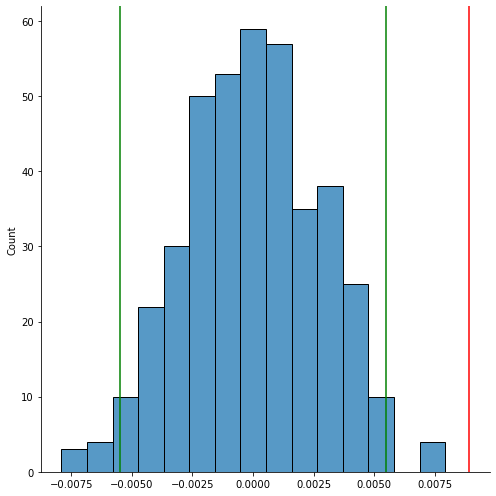

In [31]:
sns.displot(permution_result, height=7)
plt.axvline(active_rate_dif, 1, 0, color='red')
plt.axvline(left_int, 1, 0, color='green')
plt.axvline(right_int, 1, 0, color='green')

*Наблюдаем, что в 95% доверительный интервал наша разница в 0.0089 не попадает. **Она значима**.*

*Так же применим критерий хи-квадрат*

**H0**: *доля активных пользователей не зависит от группы*

**H1**: *статистически различие между долей активных пользователей*

In [32]:
cross_table = pd.crosstab(merge_data.grp, merge_data.isactive, margins=True)
cross_table

isactive,False,True,All
grp,,,
A,13155,1538,14693
B,53080,6803,59883
All,66235,8341,74576


In [33]:
expected, observed, stats  = pg.chi2_independence(merge_data, 'grp', 'isactive')

In [34]:
expected, observed, stats

(isactive       False      True 
 grp                            
 A         13049.6521  1643.3479
 B         53185.3479  6697.6521,
 isactive    False   True 
 grp                      
 A         13154.5  1538.5
 B         53080.5  6802.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  9.379875  1.0  0.002194  0.011215  0.864920
 1        cressie-read  0.666667  9.424791  1.0  0.002141  0.011242  0.866505
 2      log-likelihood  0.000000  9.516250  1.0  0.002037  0.011296  0.869680
 3       freeman-tukey -0.500000  9.586295  1.0  0.001960  0.011338  0.872066
 4  mod-log-likelihood -1.000000  9.657611  1.0  0.001886  0.011380  0.874455
 5              neyman -2.000000  9.804152  1.0  0.001741  0.011466  0.879240)

p_value < 0.05

*Вывод: доля активных (кто зашел на плаформу) пользователей в экспериментальной группе (Б) **значимо** отличается*

**Анализируем действия активных клиентов**

In [35]:
active_data = merge_data.query('isactive == True')
active_data['purchase'] = active_data.rev.apply(lambda x: 1 if x > 0 else 0)
active_data.head()

<ipython-input-35-174c3a19815b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_data['purchase'] = active_data.rev.apply(lambda x: 1 if x > 0 else 0)


,id,grp,isactive,rev,purchase
1,1627,A,True,990.0,1
10,2085,B,True,0.0,0
12,2215,B,True,0.0,0
43,3391,A,True,0.0,0
45,3401,B,True,0.0,0


In [36]:
active_group = active_data.groupby('grp').agg(mean_order_include_0_checks=('rev', 'mean'), cr=('purchase', 'mean'))
active_group

,mean_order_include_0_checks,cr
grp,,
A,47.347204,0.050715
B,58.058798,0.046156


In [37]:
active_a = active_data.query('grp == "A"')
active_b = active_data.query('grp == "B"')
a_len, b_len = len(active_a), len(active_b)
f'size a :{a_len}, size b:{b_len}'

'size a :1538, size b:6803'

*разница в CR*

In [38]:
diff_ct_active = active_group.cr[1] - active_group.cr[0]
diff_ct_active

-0.004559106964780894

*Так же воспользуемся методом перестановочных тестов*

In [39]:
active_permition = permutation_test(active_a, active_b, 'purchase', np.mean, 1000)

*Возвращает среднее и доверительный интервал исходя из предположения что данные нормально распределены*

In [40]:
mean, left_int, right_int = mean_confidence_interval(active_permition)
left_int, right_int 

(-0.0118, 0.0115)

*Проверим по экспериментальным данным:*

In [41]:
np.quantile(active_permition, 0.025), np.quantile(active_permition, 0.975)

(-0.01138467367051215, 0.01173380825066276)

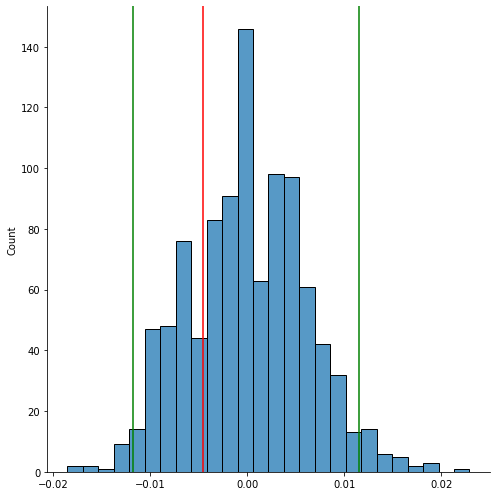

In [42]:
sns.displot(active_permition, height=7)
plt.axvline(left_int, 1, 0, color='green')
plt.axvline(right_int, 1, 0, color='green')
plt.axvline(diff_ct_active, 1, 0, color='red')

*разница CR в оплату у активных пользователей группы Б и группы А различно (0.0045) но не значимо. Попадает в доверительный интервал [-0.0123, 0.0116] при расчете статистики во время перестановочных тестов. Не можем отвергнуть случайную природу этих изменений*

*Посмотрим на распределение оплаченных чеков*

In [43]:
active_posit_rev = active_data.query('rev > 0')

C:\Users\1\anaconda3\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\1\anaconda3\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


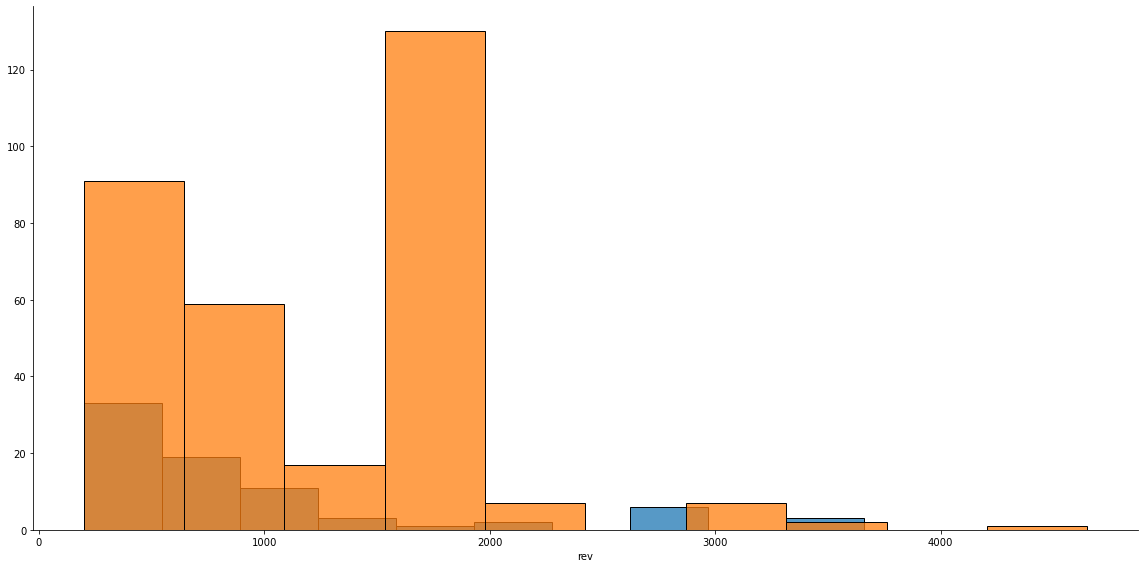

In [44]:
g = sns.FacetGrid(active_posit_rev, height=8, aspect=2, hue='grp')
g.map(sns.histplot, "rev", bins=10)

*Видим выброс в районе 1900 у экспереминтальной (Б) группы. Необходимо выяснить природу этого выброса. Возможно у этой группы был доступ к какой-либо акции, или фактору лояльности. Если это так, то нарушается принцип проведения А/Б тестирования, а именно включение какого-то доп фактора изолировано к одной группе.*

***Проверим средний чек (ARPPU)***

*Отбросим чек = 0* 

In [45]:
mean_order_permition = permutation_test(active_a.query('rev > 0'), active_b.query('rev > 0'), 'rev', np.mean, 1000)

In [46]:
# возвращает среднее, 0.025 процентиль, 0.975 процентиль
mean, left_int, right_int = mean_confidence_interval(mean_order_permition)

In [47]:
left_int, right_int

(-201.9557, 204.8603)

*Разница в среднем чеке*

In [48]:
active_group

,mean_order_include_0_checks,cr
grp,,
A,47.347204,0.050715
B,58.058798,0.046156


In [49]:
diff_check_active = active_b.query('rev > 0').rev.mean() - active_a.query('rev > 0').rev.mean()
diff_check_active

324.2892484484729

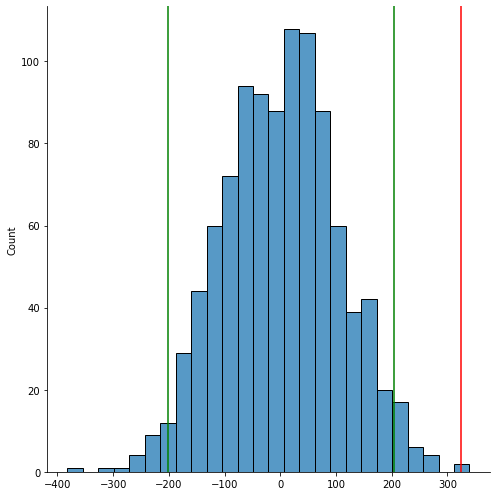

In [50]:
sns.displot(mean_order_permition, height=7)
plt.axvline(left_int, 1, 0, color='green')
plt.axvline(right_int, 1, 0, color='green')
plt.axvline(diff_check_active, 1, 0, color='red')

*разница Среднего оплаченного чека у группы А и группы Б (=324) - значима.Не попадает в доверительный интервал [-216, 208] при расчете статистики во время перестановочных тестов. Что не удивительно, учитывая выбросы (?) в группе Б*

In [53]:
pg.ttest(active_a.query('rev > 0').rev, active_b.query('rev > 0').rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


TTest показал значимое отличие между средними чеками у двух групп.

**Проведем такой же тест, но уберем чеки вблизи 1900**

In [54]:
active_b.rev.value_counts().head(7)

0.0000       6489
1900.0000      93
290.0000       45
1900.0001      35
199.0000       27
840.0000       21
990.0000       17
Name: rev, dtype: int64

*Уберем все чеки в районе 1900 у обоих групп*

In [55]:
active_posit_rev_new = active_posit_rev[active_posit_rev.rev.round() != 1900]
active_posit_rev_new

,id,grp,isactive,rev,purchase
1,1627,A,True,990.0,1
220,100300,B,True,990.0,1
320,108270,B,True,290.0,1
4187,274352,B,True,690.0,1
4399,280036,B,True,199.0,1
...,...,...,...,...,...
74017,5556966,B,True,290.0,1
74022,5557468,A,True,290.0,1
74079,5567520,A,True,489.0,1
74118,5577840,A,True,590.0,1


C:\Users\1\anaconda3\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\Users\1\anaconda3\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


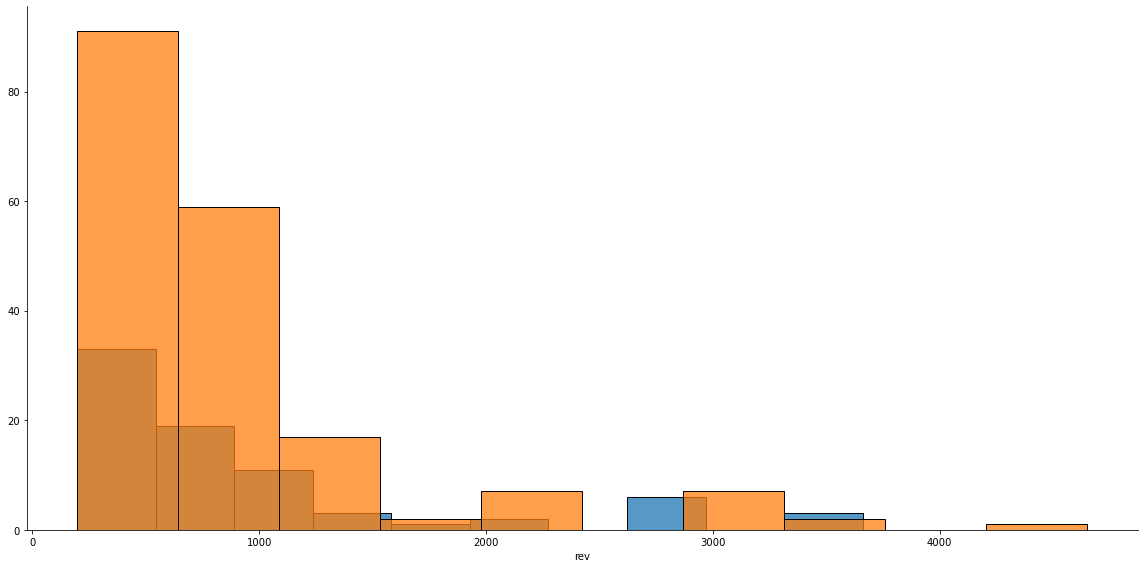

In [56]:
g = sns.FacetGrid(active_posit_rev_new, height=8, aspect=2, hue='grp')
g.map(sns.histplot, "rev", bins=10)

In [57]:
active_a = active_posit_rev_new[active_posit_rev_new.grp=='A']
active_b_new = active_posit_rev_new[active_posit_rev_new.grp=='B']

In [58]:
mean_order_permition = permutation_test(active_a, active_b_new, 'rev', np.mean, 1000)

проведем Ttest.
H0 - средние у двух групп могут быть получены из одной генеральной совокупности
H1 - средние значимо отличаются

In [59]:
pg.ttest(active_a.rev, active_b_new.rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.995692,123.105894,two-sided,0.321353,"[-116.19, 351.39]",0.145211,0.235,0.188635


*Провели тест, посчитали дов. интервал*

In [60]:
mean, left_int, right_int = mean_confidence_interval(mean_order_permition)
left_int, right_int 

(-216.485, 223.5461)

In [61]:
diff_check_active = active_a.rev.mean() - active_b_new.rev.mean()
diff_check_active

117.60049627791557

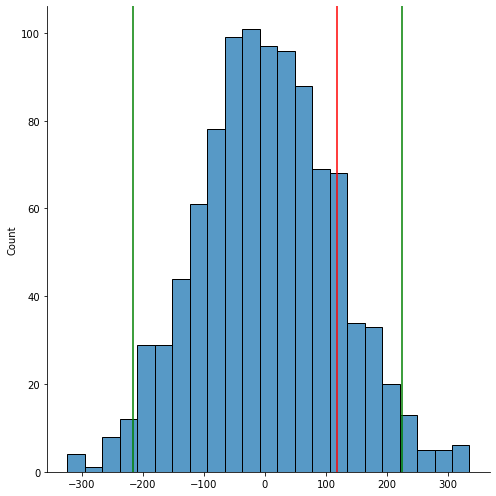

In [62]:
sns.displot(mean_order_permition, height=7)
plt.axvline(left_int, 1, 0, color='green')
plt.axvline(right_int, 1, 0, color='green')
plt.axvline(diff_check_active, 1, 0, color='red')

*Когда мы убрали у группы Б чеки в районе 1900 значимую разницу в **ARPPU** уже не наблюдаем.*

*TTEST также не показал значимых различий. Не можем отвергнуть **нулевую** гипотезу.*

**Проверим ARPU**, чеки 1900 вернем

In [63]:
active_data.groupby('grp', as_index=False).agg({'rev': 'mean'})

,grp,rev
0,A,47.347204
1,B,58.058798


In [64]:
active_a = active_data[active_data.grp=='A']
active_b = active_data[active_data.grp=='B']

In [65]:
mean_order_permition = permutation_test(active_a, active_b, 'rev', np.mean, 1000)

In [66]:
mean, left_int, right_int = mean_confidence_interval(mean_order_permition)
left_int, right_int

(-17.0308, 17.4029)

In [67]:
diff_check_active = active_b.rev.mean() - active_a.rev.mean()
diff_check_active

10.711593942529376

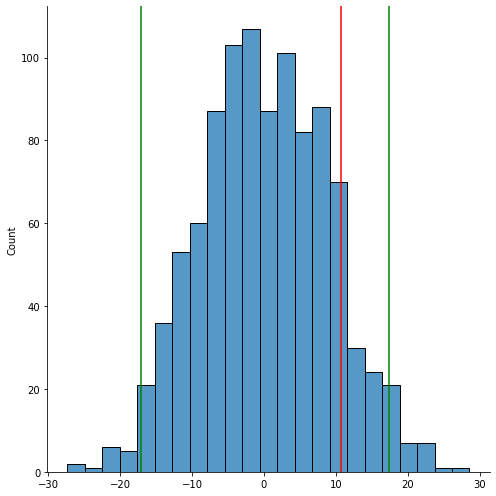

In [68]:
sns.displot(mean_order_permition, height=7)
plt.axvline(left_int, 1, 0, color='green')
plt.axvline(right_int, 1, 0, color='green')
plt.axvline(diff_check_active, 1, 0, color='red')

*Тем не менее **ARPU** у групп значимо не отличается. Находится в пределах доверительного интервала теста случайных перестановок.*

### ВЫВОДЫ

1) При анализе активных пользователей получили:

    Конверсия в покупку у группы А и Б значимо не отличается
    Различия в ARPPU значимо отличаются с учетом большого количества чеков 1900 у группы Б, без них отличия не стат значимы
    Так же ARPU не показало стат значимых отличий
    
2) При анализе конверсии в активных пользователей получили:

    Конверсия в активных пользователей значимо отличается.
    Видимо была допущена ошибка при формировании групп для А/Б тестирования.
    Возможно, в группу Б попало больше людей с недавней датой регистрации или,
    моделируя ситуацию с учетом выбросов у чеков группы Б, могу предположить, что, возможно, им пришло пуш уведомление
    с предложение какого-либо акционного товара. Это бы объяснило поведение этой группы.

***Я бы не рекомендовал выкатывать обновления, скорее всего допущены ошибки при выполнении и подготовки АБ теста.
Следует провести его повторно.***

### Задание 2. SQL ###

#### 2.1 Очень усердные ученики. ####

**2.1 Условие**

*Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень **усердным** учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.*

In [74]:
connection_default = {
    'host': 'http://clickhouse.beslan.pro:8080',
    'database':'default',
    'user':'student',                   
    'password':'dpo_python_2020'
}

In [75]:
query_2_1 = """
SELECT DISTINCT toStartOfMonth(timest)
FROM default.peas
"""
ph.read_clickhouse(query_2_1, connection=connection_default)


,toStartOfMonth(timest)
0,2021-10-01


*Данные есть только за 2021-10-01*

In [76]:
query_2_1 = """
SELECT COUNT(st_id) as count_good_student
FROM(
    SELECT st_id, sum(correct) as correct_answers
    FROM peas 
    GROUP BY toStartOfMonth(timest), st_id
    HAVING correct_answers >= 20
)
"""

In [77]:
data = ph.read_clickhouse(query_2_1, connection=connection_default)
data

,count_good_student
0,136


In [78]:
f'Количество усердных учеников: {data.count_good_student[0]}'

'Количество усердных учеников: 136'

#### Оптимизация воронки. ####

**2.1 Условие**

*Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.*

In [79]:
query_2_2 = """
SELECT 
    group,
    SUM(total_money) / COUNT(id) as ARPU,
    sumIf(total_money, is_active == 1) / SUM(is_active) as ARPAU,
    SUM(is_purchase) / COUNT(id) as CR,
    sumIf(is_purchase, is_active == 1) / SUM(is_active) as CR_per_active,
    sumIf(math_purchase, math_active == 1) / SUM(math_active) as CR_math
FROM 
(   
    SELECT 
        studs.st_id as id,
        CASE WHEN sum(peas.correct) > 10 THEN 1 ELSE 0 END as is_active,
        CASE WHEN countIf(peas.st_id, peas.subject == 'Math') >= 2 THEN 1 ELSE 0 END as math_active
    FROM peas
    FULL JOIN studs ON peas.st_id == studs.st_id
    GROUP BY studs.st_id
) as active_table
LEFT JOIN
(
    SELECT 
        studs.st_id as id,
        any(test_grp) as group,
        sum(money) as total_money,
        CASE WHEN sum(money) > 0 THEN 1 ELSE 0 END as is_purchase,
        CASE WHEN sumIf(money, subject == 'Math') > 0 THEN 1 ELSE 0 END as math_purchase 
    FROM studs
    LEFT JOIN final_project_check on studs.st_id == final_project_check.st_id
    GROUP BY studs.st_id
) as purchase_table 
ON active_table.id == purchase_table.id
GROUP BY group
"""

In [80]:
data = ph.read_clickhouse(query_2_2, connection=connection_default)
data

,group,ARPU,ARPAU,CR,CR_per_active,CR_math
0,control,4540.983607,10393.700787,0.049180,0.110236,0.060000
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.090909


### Задание 3. PYTHON ###

**3.1 Условие**

*Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.*

**3.2 Условие**

*Реализуйте функцию, которая будет строить графики по получаемым метрикам.*

**3.1**

In [81]:
import re

In [82]:
def update_groups(base_df: pd.DataFrame, check_df: pd.DataFrame, active_studs: pd.DataFrame, add_df: Union[pd.DataFrame, str]): 
    """
    Take 2 DataFrames and try to merge it, calculate matrics
    """
    if isinstance(add_df, (pd.DataFrame, str)) and isinstance(base_df, pd.DataFrame) and isinstance(check_df, pd.DataFrame) \
                                                        and isinstance(active_studs, pd.DataFrame):
        if type(add_df) == str:
            # Если дана строка, предполагаем, что это ссылка. Выгружаем данные по ней
            add_df_url = re.escape(add_df)
            add_df = get_ydisc_public_data_csv(groups_add_url)
        
        add_types = add_df.dtypes
        add_shape = add_df.shape
        # Проверяем, что в дополнительном файле 2 колонки. Одна из них типа numeric (id), другая object (группы А/Б)
        if add_shape[1] == 2 and any([pd.api.types.is_numeric_dtype(d_type) for d_type in add_types]) \
                            and any([pd.api.types.is_object_dtype(d_type) for d_type in add_types]):
            # Переименовываем колонку с типом данных numeric в 'id', с object в grp
            columns_rename_dict = dict(((groups_add.select_dtypes(include=np.number).columns[0], 'id'), (groups_add.select_dtypes(include=np.object0).columns[0], 'grp')))
            add_df.rename(columns_rename_dict, inplace=True)
            
            add_df = add_df[['id', 'grp']]
            groups_id = groups.id
            # Проверяем, находятся ли уже данные по этим айдишникам в основном файле, чтобы не было дупликации. 
            add_df = add_df.query('id not in @groups_id')
            all_groups = pd.concat([base_df, add_df])
            all_groups['isactive'] = all_groups.id.isin(active_studs.student_id)
            # Объединяем все данные которые есть, обрабатываем
            merge_data = all_groups.merge(check_df, left_on='id', right_on='student_id', how='left', )
            merge_data.drop(columns=['student_id'],inplace=True)
            merge_data.fillna({'rev': 0}, inplace=True)
            active_data = merge_data[merge_data.isactive == True]
            # Разделяем группы, считаем метрики
            group_a = active_data[active_data.grp == 'A']
            group_b = active_data[active_data.grp == 'B']
            CR_A = round(group_a.rev.apply(lambda x: 1 if x > 0 else 0).mean(), 4)
            CR_B = round(group_b.rev.apply(lambda x: 1 if x > 0 else 0).mean(), 4)
            ARPU_A = group_a.rev.mean()
            ARPU_B = group_b.rev.mean()
            ARPPU_A = round(group_a[group_a.rev > 0].rev.mean(), 1)
            ARPPU_B = round(group_b[group_b.rev > 0].rev.mean(), 1)
            
            
            metrics_data = pd.DataFrame([['A', CR_A, ARPPU_A, ARPPU_A], ['B', CR_B, ARPPU_B, ARPPU_B],], columns=['Group', 'CR', 'ARPU', 'ARPPU'])
            
            return metrics_data
        else:
            raise ValueError('Value Error: Additional DataFrame must have 2 columns: id (numeric), grp(object)')
            
    else:
        raise TypeError('TypeError: base_df: pd.DataFrame, check_df: pd.DataFrame, active_studs: pd.DataFrame, add_df: pd.DataFrame or str') 
    

In [83]:
def plot_graphics(data_metrics: pd.DataFrame):
    """
    Рисует по полученным метрикам графики
    """
    data_metrics.plot(x='Group', y='CR', kind='bar', figsize=(10, 5))
    data_metrics.plot(x='Group', y='ARPU', kind='bar', figsize=(10, 5))
    data_metrics.plot(x='Group', y='ARPPU', kind='bar', figsize=(10, 5))
    

In [84]:
data_metrics = update_groups(groups, checks, active_studs, groups_add_url)
data_metrics

,Group,CR,ARPU,ARPPU
0,A,0.0507,933.6,933.6
1,B,0.0462,1257.9,1257.9


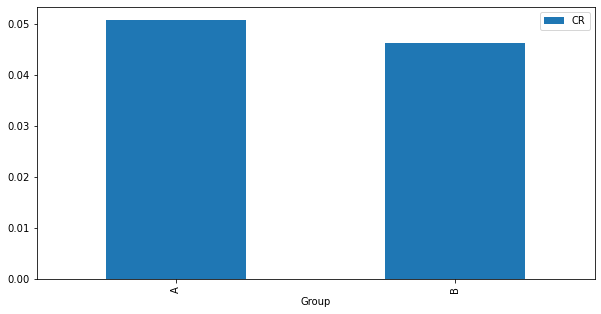

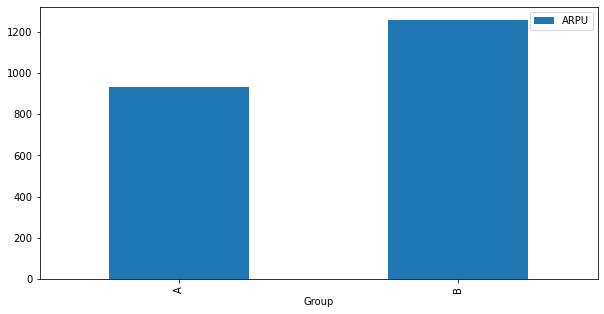

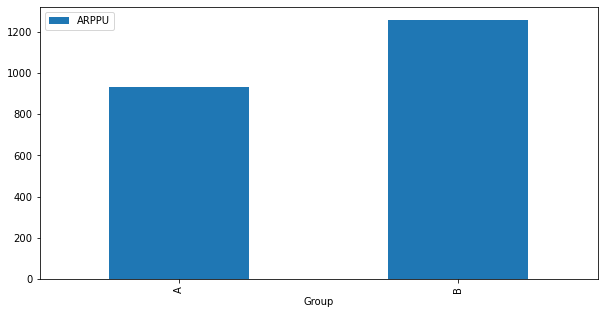

In [85]:
plot_graphics(data_metrics)